In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectrum as spectrum
import darkhistory.spec.spectra as spectra
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt
import pickle

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [3]:
transfer_func_table = pickle.load(open(
    "/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw", "rb")
)

In [4]:
eng = np.array([transfer_func.in_eng 
                for transfer_func in transfer_func_table])
tf_rs_arr = np.array([spec.rs for spec in transfer_func_table[0]])

In [5]:
# Transfer function is normalized to 1 particle in the bin.
# To use the transfer function on dN/dE, need to further normalize.
norm_spec = spectools.rebin_N_arr(np.ones(eng.size), eng, eng)

In [6]:
#Initialize
eng_ind = 99
mwimp = eng[eng_ind]
print(mwimp)

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[20]), 
                           -0.002)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

207661.364379


In [7]:
print(np.log(tf_rs_arr[0]))
print(np.log(tf_rs_arr[1]))

3.43398720449
3.39303334762


In [8]:
photon_spectra = spectra.Spectra([photon_spec_init])
append = photon_spectra.append

# List of transfer functions interpolated at rs_list, indexed by injection energy.
# Perform the normalization properly. 
tf_at_rs_list = [transfer_func.at_rs(rs_list)/norm_spec.dNdE[i]
                 for i,transfer_func in 
                 zip(np.arange(norm_spec.length), tqdm(transfer_func_table))]


In [9]:
for i in tqdm(np.arange(rs_list.size-1).astype(int)):
    tf_at_rs = spectra.Spectra([transfer_func[i]
                             for transfer_func in tf_at_rs_list])
    append(tf_at_rs.sum_specs(photon_spectra[-1]))
    photon_spectra[-1].rs = rs_list[i+1]


In [10]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [11]:
file[1].data['photonspectrum'][0,:,:].shape

(2049, 500)

In [12]:
# file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
#                    for photspec,rs in zip(file_photonspectrum, file_rs)], 
#                 rebin_eng = eng)

file_spectra = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_spectra_orig = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

13.9291978876
13.9291978876


/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:604: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0.0001, 10000000000000.0, 1e-22, 1000.0]

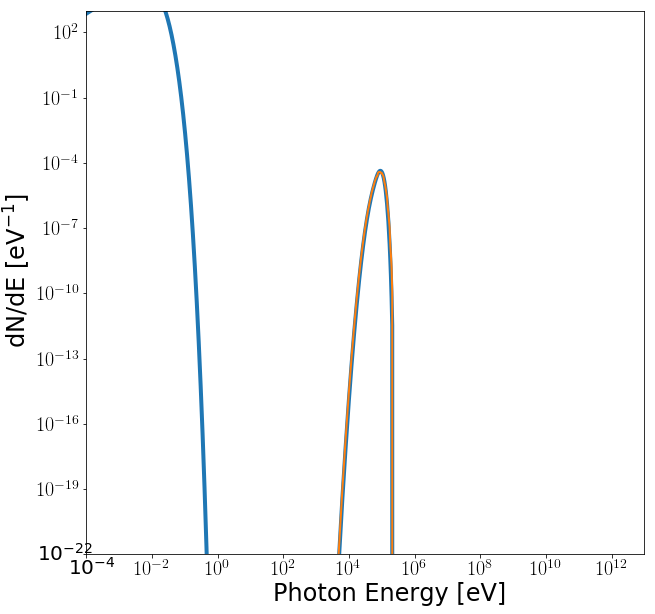

In [13]:
i=400
j=800
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

spec_to_plot = photon_spectra[i]
spec_to_plot.rebin(file_spectra.eng)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
plt.plot(file_spectra.eng, file_spectra[j].dNdE, linewidth=4)
plt.plot(spec_to_plot.eng, spec_to_plot.dNdE, linewidth=2)
# plt.plot(photon_spectra.eng, photon_spectra[i].dNdE, linewidth=2)
# plt.plot(file_spectra[j].eng, file_spectra[j].dNdE)

# plt.plot(photon_spectra.eng, photon_spectra[i].totN('bin',np.arange(501)))
# plt.plot(file_spectra[j].eng, file_spectra[j].totN('bin',np.arange(501)))
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel('dN/dE [eV$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-22, 1e3])
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')


In [14]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].dNdE,
#                    file_spectra[j].eng,
                   file_spectra[j].dNdE,
                   file_spectra[j+1].dNdE
                   ])

207661.364379
[[  1.02296232e-04   0.00000000e+00   7.43156555e+02   7.41919495e+02]
 [  1.07048086e-04   0.00000000e+00   7.77084351e+02   7.75790344e+02]
 [  1.12020673e-04   0.00000000e+00   8.12532043e+02   8.11177856e+02]
 [  1.17224246e-04   0.00000000e+00   8.49564636e+02   8.48148071e+02]
 [  1.22669536e-04   0.00000000e+00   8.88250244e+02   8.86769470e+02]
 [  1.28367769e-04   0.00000000e+00   9.28659973e+02   9.27110229e+02]
 [  1.34330696e-04   0.00000000e+00   9.70866272e+02   9.69245483e+02]
 [  1.40570612e-04   0.00000000e+00   1.01494495e+03   1.01324963e+03]
 [  1.47100384e-04   0.00000000e+00   1.06097583e+03   1.05920178e+03]
 [  1.53933476e-04   0.00000000e+00   1.10903833e+03   1.10718396e+03]
 [  1.61083979e-04   0.00000000e+00   1.15921912e+03   1.15727991e+03]
 [  1.68566636e-04   0.00000000e+00   1.21160620e+03   1.20957678e+03]
 [  1.76396877e-04   0.00000000e+00   1.26628857e+03   1.26416650e+03]
 [  1.84590847e-04   0.00000000e+00   1.32336060e+03   1.321139

0

In [15]:
bin_width = spectools.get_log_bin_width(file_spectra_orig[1].eng)*file_spectra_orig[1].eng

# utils.compare_arr([tf_at_rs_list[eng_ind].eng,tf_at_rs_list[eng_ind][0].dNdE, 
#                    file_spectra_orig[1].eng, file_spectra_orig[1].dNdE*bin_width])

utils.compare_arr([file_spectra_orig[1].eng, file_spectra_orig[1].dNdE*bin_width, 
                   file_spectra_orig[2].dNdE*bin_width])


[[  1.02296232e-04   8.62482484e-03   8.62010634e-03]
 [  1.07048086e-04   9.44127104e-03   9.43609484e-03]
 [  1.12020673e-04   1.03348144e-02   1.03291469e-02]
 [  1.17224246e-04   1.13127321e-02   1.13065141e-02]
 [  1.22669536e-04   1.23829477e-02   1.23761404e-02]
 [  1.28367769e-04   1.35541425e-02   1.35466889e-02]
 [  1.34330696e-04   1.48358157e-02   1.48276391e-02]
 [  1.40570612e-04   1.62383192e-02   1.62293810e-02]
 [  1.47100384e-04   1.77730191e-02   1.77632320e-02]
 [  1.53933476e-04   1.94523261e-02   1.94415895e-02]
 [  1.61083979e-04   2.12897742e-02   2.12780156e-02]
 [  1.68566636e-04   2.33001844e-02   2.32873078e-02]
 [  1.76396877e-04   2.54997429e-02   2.54856425e-02]
 [  1.84590847e-04   2.79061529e-02   2.78907119e-02]
 [  1.93165443e-04   3.05387761e-02   3.05218642e-02]
 [  2.02138345e-04   3.34187212e-02   3.34001990e-02]
 [  2.11528055e-04   3.65691001e-02   3.65487797e-02]
 [  2.21353936e-04   4.00150652e-02   3.99928120e-02]
 [  2.31636247e-04   4.37842

0

In [16]:
utils.compare_arr([file_eng,file_photonspectrum[1],file_photonspectrum[2],
                   file_photonspectrum[3]])

[[  1.02296232e-04   1.85688110e+03   1.85586523e+03   1.85484509e+03]
 [  1.07048086e-04   1.94242834e+03   1.94136340e+03   1.94029419e+03]
 [  1.12020673e-04   2.03187952e+03   2.03076526e+03   2.02964636e+03]
 [  1.17224246e-04   2.12541382e+03   2.12424561e+03   2.12307715e+03]
 [  1.22669536e-04   2.22321143e+03   2.22198926e+03   2.22076416e+03]
 [  1.28367769e-04   2.32546338e+03   2.32418457e+03   2.32290259e+03]
 [  1.34330696e-04   2.43236987e+03   2.43102930e+03   2.42968799e+03]
 [  1.40570612e-04   2.54413403e+03   2.54273364e+03   2.54133008e+03]
 [  1.47100384e-04   2.66097534e+03   2.65951001e+03   2.65804102e+03]
 [  1.53933476e-04   2.78311987e+03   2.78158374e+03   2.78004663e+03]
 [  1.61083979e-04   2.91079858e+03   2.90919092e+03   2.90757959e+03]
 [  1.68566636e-04   3.04425610e+03   3.04257373e+03   3.04088770e+03]
 [  1.76396877e-04   3.18374561e+03   3.18198511e+03   3.18022046e+03]
 [  1.84590847e-04   3.32953247e+03   3.32769019e+03   3.32584351e+03]
 [  1.

0

[1000.0, 200000000000.0, 1e-20, 1000.0]

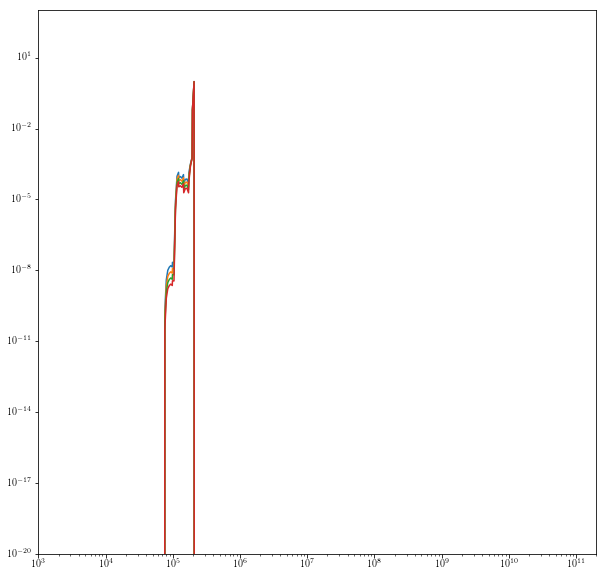

In [17]:
a_fig=tf_at_rs_list[eng_ind].plot((2,400),step=100)
a = a_fig.get_axes()[0]
a.set_xscale('log')
a.set_yscale('log')
plt.axis([1e3, 2e11, 1e-20, 1e3])

In [18]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].totN('eng', spectools.get_bin_bound(photon_spectra[i].eng)),
                   file_spectra[j].totN('eng', spectools.get_bin_bound(photon_spectra[i].eng)) 
                   ])

207661.364379
[[  1.02296232e-04   0.00000000e+00   3.45180696e-03]
 [  1.07048086e-04   0.00000000e+00   3.77705772e-03]
 [  1.12020673e-04   0.00000000e+00   4.13280798e-03]
 [  1.17224246e-04   0.00000000e+00   4.52189452e-03]
 [  1.22669536e-04   0.00000000e+00   4.94741804e-03]
 [  1.28367769e-04   0.00000000e+00   5.41276623e-03]
 [  1.34330696e-04   0.00000000e+00   5.92162947e-03]
 [  1.40570612e-04   0.00000000e+00   6.47803920e-03]
 [  1.47100384e-04   0.00000000e+00   7.08640302e-03]
 [  1.53933476e-04   0.00000000e+00   7.75150775e-03]
 [  1.61083979e-04   0.00000000e+00   8.47860562e-03]
 [  1.68566636e-04   0.00000000e+00   9.27341423e-03]
 [  1.76396877e-04   0.00000000e+00   1.01421524e-02]
 [  1.84590847e-04   0.00000000e+00   1.10916182e-02]
 [  1.93165443e-04   0.00000000e+00   1.21292101e-02]
 [  2.02138345e-04   0.00000000e+00   1.32630081e-02]
 [  2.11528055e-04   0.00000000e+00   1.45018071e-02]
 [  2.21353936e-04   0.00000000e+00   1.58551906e-02]
 [  2.31636247

0

In [19]:
tf_rs_31 = spectra.Spectra([transfer_func[0] for transfer_func in tf_at_rs_list])

[1000.0, 200000000000.0, 1e-20, 1000.0]

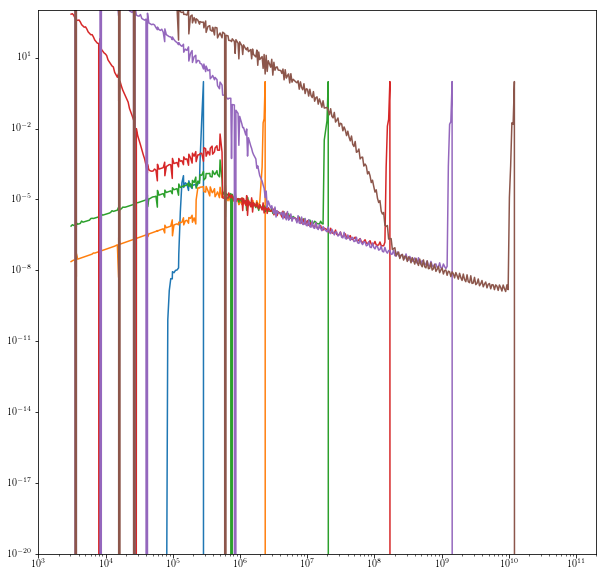

499/|/100%|| 499/500 [00:50<00:00,  9.98it/s]

In [20]:
a_fig = tf_rs_31.plot((106, 399),step=50)
a = a_fig.get_axes()[0]
a.set_xscale('log')
a.set_yscale('log')
plt.axis([1e3, 2e11, 1e-20, 1e3])